In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import src
from cartopy import crs as ccrs
import cartopy
import ac3airborne
from ac3airborne.tools import get_amsr2_seaice as seaice
import typhon as ty
import scipy.stats
import os
from dotenv import load_dotenv

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def FOSC(tau, Sb, Sm, Ib):


#### Load AC3 meta data

In [2]:
cat, meta, credentials, kwds = src.get_ac3_meta()

#### Load P5 and collocated data

In [3]:
lwp_campaign_p5 = xr.open_dataset('/net/secaire/mringel/data/lwp_retrieved/all_campaigns_P5_lwp_v4.nc')
lwp_campaign_era5 = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/all_campaigns_ERA5_lwp_v2.nc')
lwp_campaign_aqua = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/lwp_modis/all_campaigns_P5_MODIS_aqua_lwp_v2.nc')
lwp_campaign_terra = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/lwp_modis/all_campaigns_P5_MODIS_terra_lwp_v2.nc')
lwp_campaign_amsr = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/lwp_amsr2/all_campaigns_P5_AMSR_lwp_v4.nc')

# drop all P5 NaN values (=sea ice or land)
lwp_campaign_p5_ocean = lwp_campaign_p5.dropna(dim='time')

lwp_campaign_era5 = src.get_identical_times(lwp_campaign_era5,lwp_campaign_p5_ocean)
lwp_campaign_aqua = src.get_identical_times(lwp_campaign_aqua,lwp_campaign_p5_ocean)
lwp_campaign_terra = src.get_identical_times(lwp_campaign_terra,lwp_campaign_p5_ocean)
lwp_campaign_amsr = src.get_identical_times(lwp_campaign_amsr,lwp_campaign_p5_ocean)

datasets = [
    lwp_campaign_p5_ocean,
    lwp_campaign_era5,
    lwp_campaign_aqua,
    lwp_campaign_terra,
    lwp_campaign_amsr]

labels = ['MiRAC - P5','ERA5','MODIS - Aqua','MODIS - Terra','AMSR2 - GCOM-W1']
campaigns = ['ACLOUD','AFLUX','MOSAiC-ACA','HALO-AC3']

#### Load (mean) sea ice data

In [5]:
sic_avg_aflux = xr.open_dataset('/data/obs/campaigns/aflux/auxiliary/sea_ice/avg/AFLUX_mean_sic_asi-AMSR2-n6250-v5.4.nc')
sic_avg_acloud = xr.open_dataset('/data/obs/campaigns/acloud/auxiliary/sea_ice/avg/ACLOUD_mean_sic_asi-AMSR2-n6250-v5.4.nc')
sic_avg_mosaicaca = xr.open_dataset('/data/obs/campaigns/mosaic-aca/auxiliary/sea_ice/avg/MOSAiC-ACA_mean_sic_asi-AMSR2-n6250-v5.4.nc')
sic_avg_haloac3 = xr.open_dataset('/data/obs/campaigns/halo-ac3/auxiliary/sea_ice/avg/HALO-AC3_mean_sic_asi-AMSR2-n6250-v5.4.nc')

sic_datasets = [sic_avg_acloud,sic_avg_aflux,sic_avg_mosaicaca,sic_avg_haloac3]

sic_avg_all_campaigns = (sic_avg_acloud.sic + sic_avg_aflux.sic + sic_avg_mosaicaca.sic + sic_avg_haloac3.sic)/4

#### Define a regular lat-lon grid

In [6]:
lonmin = -5.
lonmax = 28.
latmin = 76.
latmax = 83.
grid_resolution = .5

grid_lons = np.arange(lonmin,lonmax,grid_resolution)
grid_lats = np.arange(latmin,latmax,grid_resolution)

grid_lons, grid_lats = np.meshgrid(grid_lons,grid_lats)

#### Calculate sum of collocations per gridcell

In [7]:
collocation_frequencies = np.zeros([len(datasets),grid_lons.shape[0],grid_lons.shape[1]])
lwp_uniform_grid = []

for j,dataset in enumerate(datasets):

    ds_lons = dataset.where(dataset.lwp != -9999.).lon.values
    ds_lats = dataset.where(dataset.lwp != -9999.).lat.values

    if j in [0,1,4]:
        #ds_lwp = dataset.where((dataset.lwp != -9999.)&(dataset.lwp <= 1.)).lwp.values
        ds_lwp = dataset.where(dataset.lwp != -9999.).lwp.values
        ds_lwp = ds_lwp*1000
    else: 
        #ds_lwp = dataset.where((dataset.lwp != -9999.)&(dataset.lwp <= 1000.)).lwp.values
        ds_lwp = dataset.where(dataset.lwp != -9999.).lwp.values

    lwp_grid = xr.DataArray(np.empty([len(dataset.time),grid_lons.shape[0],grid_lons.shape[1]]),dims=['time','lat','lon'])
    lwp_grid[:,:,:] = np.nan

    for t,time in enumerate(dataset.time):
            
        nn_ind, _ = src.find_nn_gridcell(grid_lons,grid_lats,
                                         ds_lons[t],ds_lats[t])
            
        if (ds_lons[t] != np.nan) and (ds_lats[t] != np.nan) & (nn_ind != (0,0)):

            collocation_frequencies[j,nn_ind[0],nn_ind[1]] += 1
            lwp_grid[t,nn_ind[0],nn_ind[1]] = ds_lwp[t]

    lwp_uniform_grid.append(lwp_grid)

collocation_frequencies_clipped = collocation_frequencies.copy()
collocation_frequencies_clipped[collocation_frequencies_clipped==0] = np.nan

lwp_means = [lwp_uniform_grid[col].mean(dim='time',skipna=True) for col in range(len(lwp_uniform_grid))]
lwp_medians = [lwp_uniform_grid[col].median(dim='time',skipna=True) for col in range(len(lwp_uniform_grid))]
lwp_iqrs = [lwp_uniform_grid[col].quantile(q=0.75,dim='time',skipna=True) - lwp_uniform_grid[col].quantile(q=0.25,dim='time') for col in range(len(lwp_uniform_grid))]

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


#### Plot collocation frequencies per gridcell for all campaigns, for each data product

Text(0.1, 1.2, 'All campaigns')

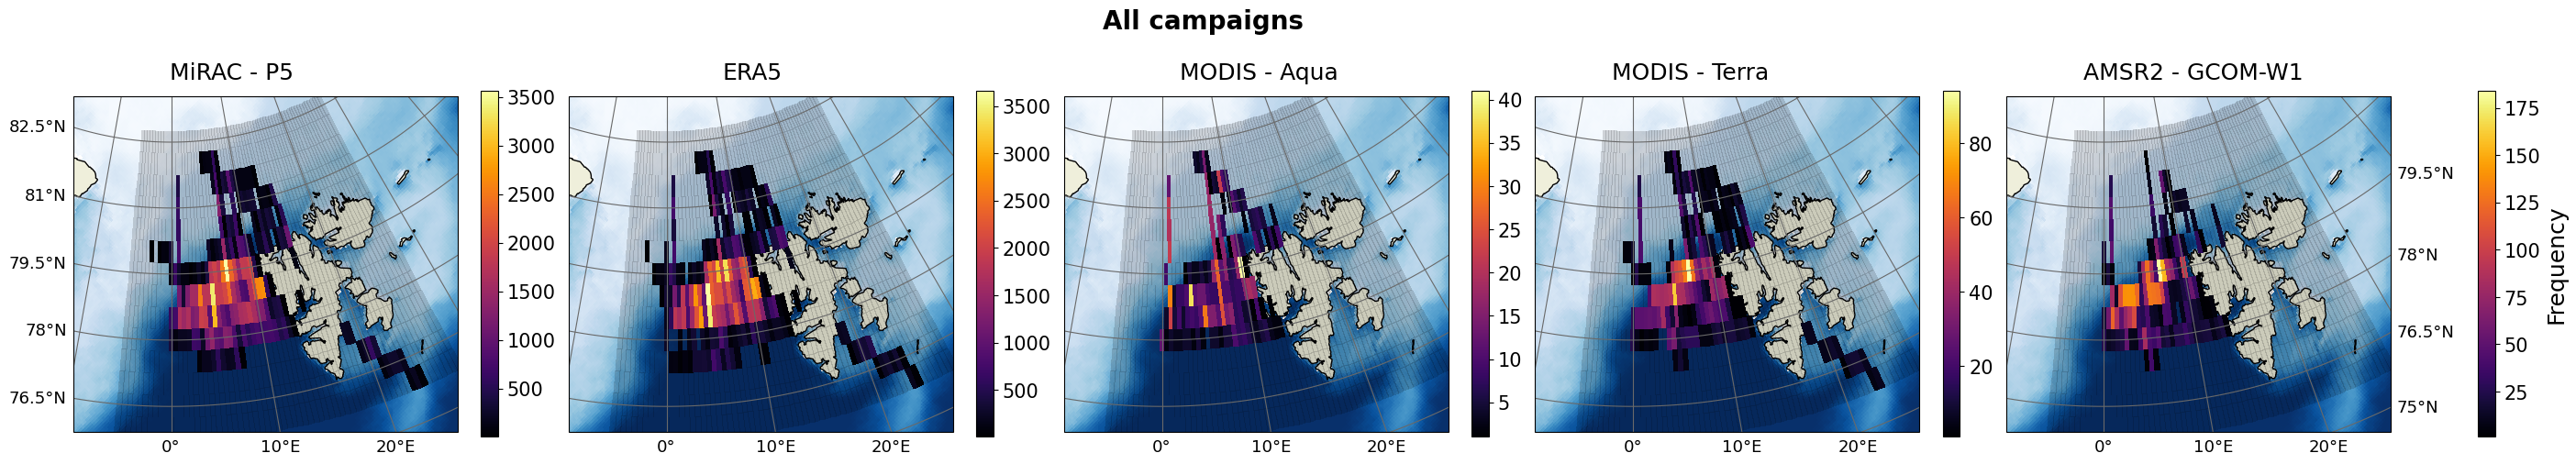

In [42]:
fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(28,5),sharey=True,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()})

nn_inds = []
coords = []
for col,dataset in enumerate(datasets):

    """
    ds_lons = dataset.lon.values
    ds_lats = dataset.lat.values

    # count frequencies of collocations in lat lon grid
    collocation_frequencies = np.zeros(grid_lons.shape)
    #nn_inds_i = []
    #coords_i = []
    for i in range(len(dataset.time)):
        
        nn_ind, _ = src.find_nn_gridcell(grid_lons,grid_lats,
                                         ds_lons[i],ds_lats[i])
        
        if (ds_lons[i] != np.nan) and (ds_lats[i] != np.nan) & (nn_ind != (0,0)):

            collocation_frequencies[nn_ind] += 1

        #nn_inds_i.append(nn_ind)
        #coords_i.append(np.array([ds_lons[i],ds_lats[i]]))
    
    #nn_inds.append(nn_inds_i)
    #coords.append(coords_i)
    """

    axs[col].set_extent([-9., 27.25, 75.75, 82.75], crs=ccrs.PlateCarree())

    # plot sea-ice concentration
    axs[col].pcolormesh(
        sic_avg_all_campaigns.lon,sic_avg_all_campaigns.lat,sic_avg_all_campaigns,
        cmap='Blues_r',
        transform=ccrs.PlateCarree())

    # plot land
    axs[col].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

    # gridlines
    gl = axs[col].gridlines(color='dimgray',draw_labels=True,
                            x_inline=False, y_inline=False,
                            zorder=1,transform=ccrs.PlateCarree())
    gl.rotate_labels = False
    if col == 0:
        gl.right_labels = False
        gl.top_labels = False
    if col in [1,2,3]:
        gl.right_labels = False
        gl.left_labels = False
        gl.top_labels = False
    if col == 4:
        gl.left_labels = False
        gl.top_labels = False
    gl.xlabel_style={'size': 13}
    gl.ylabel_style={'size': 13}

    # plot collocation frequencies
    axs[col].pcolormesh(grid_lons,grid_lats,collocation_frequencies[col],
                    cmap='inferno',alpha=0.15,
                    transform=ccrs.PlateCarree())
    pc = axs[col].pcolormesh(grid_lons,grid_lats,collocation_frequencies_clipped[col],
                    cmap='inferno',alpha=1.0,
                    transform=ccrs.PlateCarree())
    if col != 4:
        fig.colorbar(pc,
                    fraction=0.045, 
                    pad=0.06)
    if col == 4:
        fig.colorbar(pc,
                    fraction=0.045, 
                    pad=0.06, 
                    label='Frequency')

# add subtitles
axs[0].text(0.25,1.05,labels[0],transform=axs[0].transAxes)
axs[1].text(0.4,1.05,labels[1],transform=axs[1].transAxes)
axs[2].text(0.3,1.05,labels[2],transform=axs[2].transAxes)
axs[3].text(0.2,1.05,labels[3],transform=axs[3].transAxes)
axs[4].text(0.2,1.05,labels[4],transform=axs[4].transAxes)

axs[2].text(0.1,1.2,'All campaigns',fontweight='bold',fontsize=20,transform=axs[2].transAxes)

#plt.savefig('/home/mringel/lwp_project/figures/map_of_collocations_all_campaigns_grid.png',
#            bbox_inches='tight',
#            dpi=200)

#### Plot collocation frequenices for each campaign, for each data product

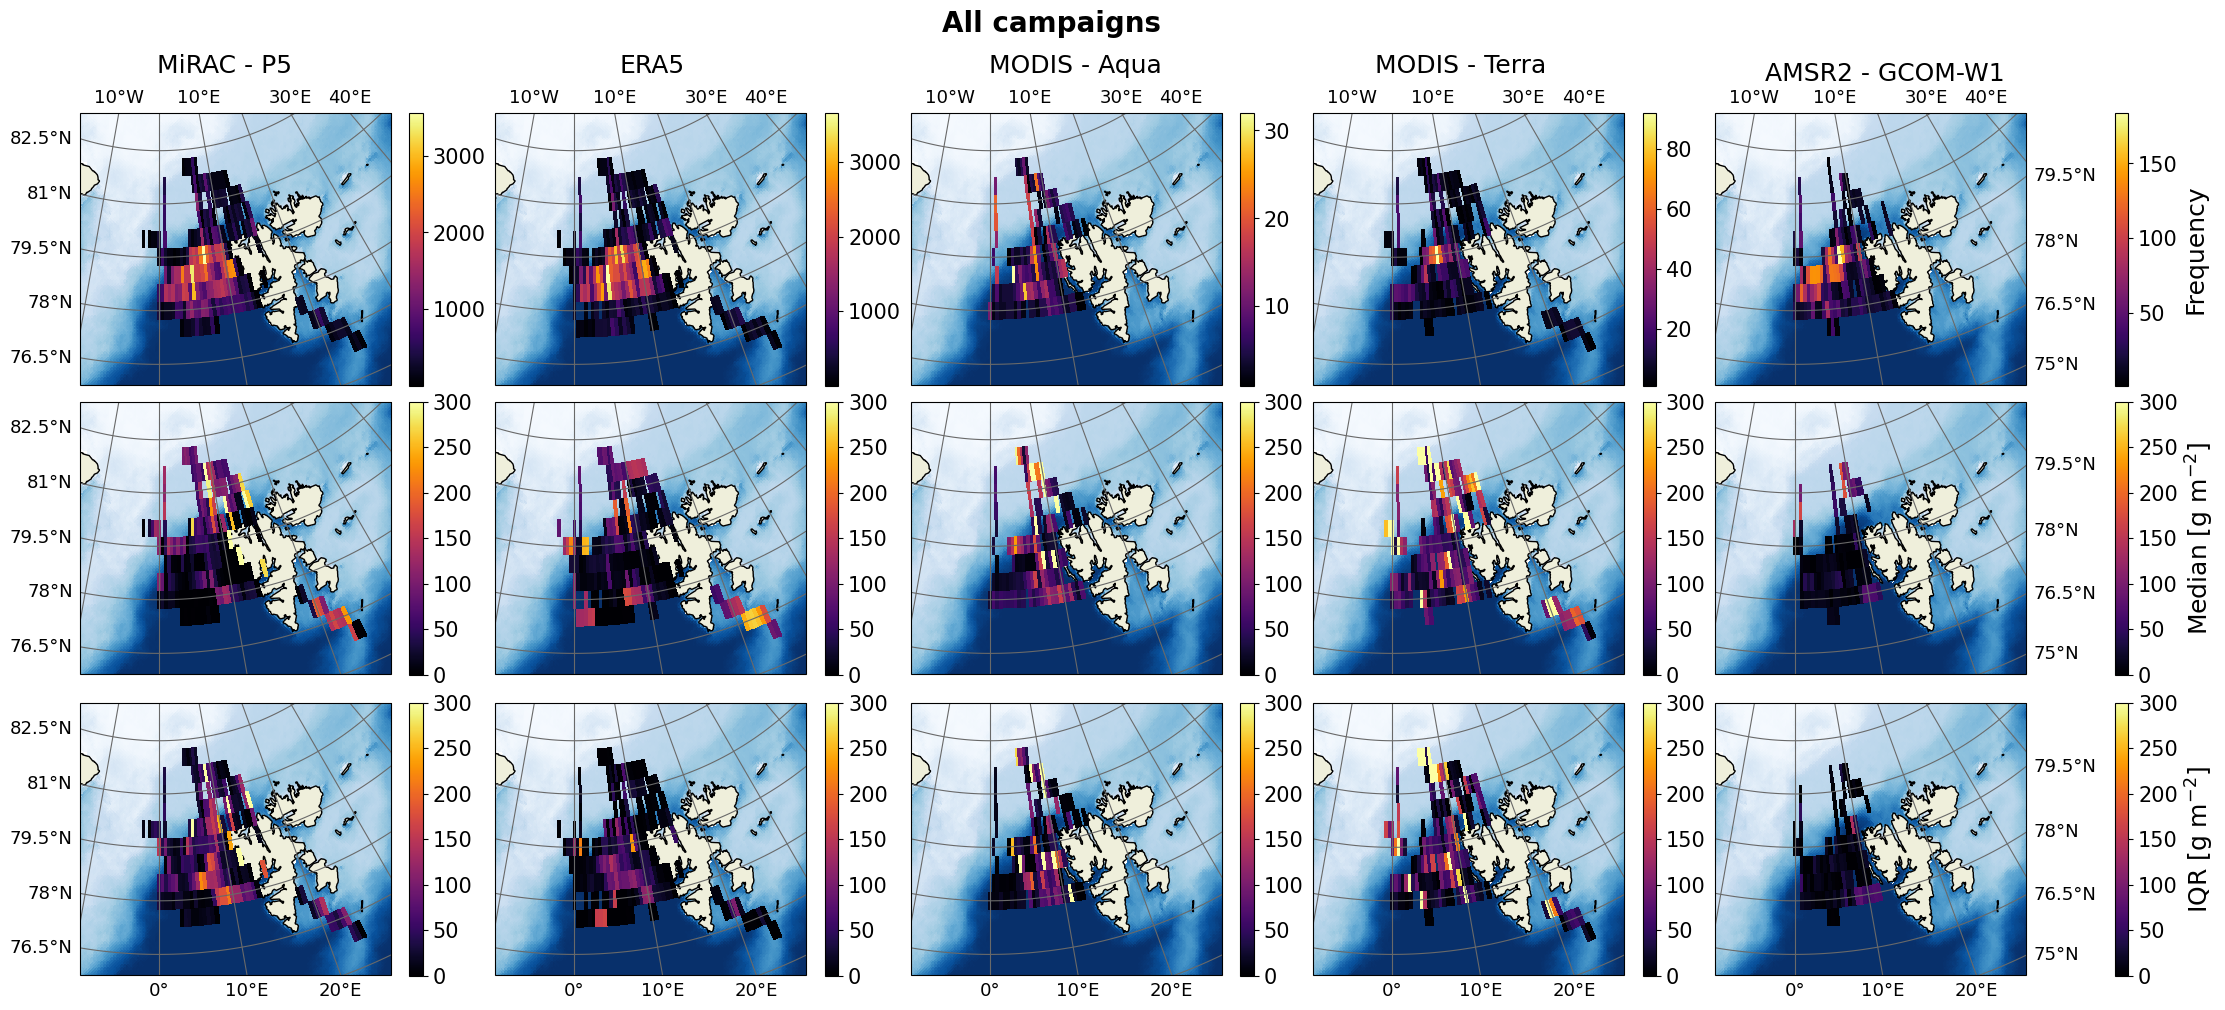

In [30]:
fig, axs = plt.subplots(nrows=3,ncols=5,figsize=(22,10),sharey=True,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()})

nn_inds = []
coords = []

data = [collocation_frequencies_clipped,lwp_medians,lwp_iqrs]

for row in range(len(data)):

    for col,dataset in enumerate(datasets):
        axs[row,col].set_extent([-9., 27.25, 75.75, 82.75], crs=ccrs.PlateCarree())

        # plot sea-ice concentration
        axs[row,col].pcolormesh(
            sic_avg_all_campaigns.lon,sic_avg_all_campaigns.lat,sic_avg_all_campaigns,
            cmap='Blues_r',
            transform=ccrs.PlateCarree())

        # plot land
        axs[row,col].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

        # gridlines
        gl = axs[row,col].gridlines(color='dimgray',draw_labels=True,
                                    x_inline=False, y_inline=False,
                                    zorder=1,transform=ccrs.PlateCarree())
        gl.rotate_labels = False
        gl.top_labels = False
        gl.bottom_labels = False
        gl.right_labels = False
        gl.left_labels = False
        
        if row == 0:
            gl.top_labels = True
        if row == 2:
            gl.bottom_labels = True
        if col == 0:
            gl.left_labels = True
        if col == 4:
            gl.right_labels = True
        
        gl.xlabel_style={'size': 13}
        gl.ylabel_style={'size': 13}

        # plot uniform grid in the background
        #axs[row,col].pcolormesh(grid_lons,grid_lats,np.zeros([grid_lons.shape[0],grid_lons.shape[1]]),
        #                cmap='inferno',alpha=0.15,
        #                transform=ccrs.PlateCarree())
        
        # plot data on top
        if row == 0:
            vmin = None
            vmax = None
        if row == 1:
            vmin = 0
            vmax = 300
        if row == 2:
            vmin = None
            vmax = 300
        pc = axs[row,col].pcolormesh(grid_lons,grid_lats,data[row][col],
                        cmap='inferno',alpha=1.0,vmin=vmin,vmax=vmax,
                        transform=ccrs.PlateCarree())
        if col != 4:
            fig.colorbar(pc,
                         fraction=0.045, 
                         pad=0.06)
        if col == 4:
            if row == 0:
                fig.colorbar(pc,
                             fraction=0.045, 
                             pad=0.06,
                             label='Frequency')
            if row == 1:
                fig.colorbar(pc,
                             fraction=0.045, 
                             pad=0.06,
                             label='Median [g m$^{-2}$]')
            if row == 2:
                fig.colorbar(pc,
                             fraction=0.045, 
                             pad=0.06,
                             label='IQR [g m$^{-2}$]')
        

# add subtitles
axs[0,0].text(0.25,1.15,labels[0],transform=axs[0,0].transAxes)
axs[0,1].text(0.4,1.15,labels[1],transform=axs[0,1].transAxes)
axs[0,2].text(0.25,1.15,labels[2],transform=axs[0,2].transAxes)
axs[0,3].text(0.2,1.15,labels[3],transform=axs[0,3].transAxes)
axs[0,4].text(0.16,1.12,labels[4],transform=axs[0,4].transAxes)

axs[0,2].text(0.1,1.3,'All campaigns',fontweight='bold',fontsize=20,transform=axs[0,2].transAxes)

plt.savefig(f'/home/mringel/lwp_project/figures/figures4poster/map_of_collocations_all_campaigns_grid_median_iqr_vmax{vmax}_v2.png',
            bbox_inches='tight',
            dpi=200)

#### Plot collocated coordinates for all campaigns, for each data product

/tmp/ipykernel_2388150/987821550.py:76: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgd.legendHandles[0]._sizes = [13]
/tmp/ipykernel_2388150/987821550.py:77: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgd.legendHandles[1]._sizes = [13]


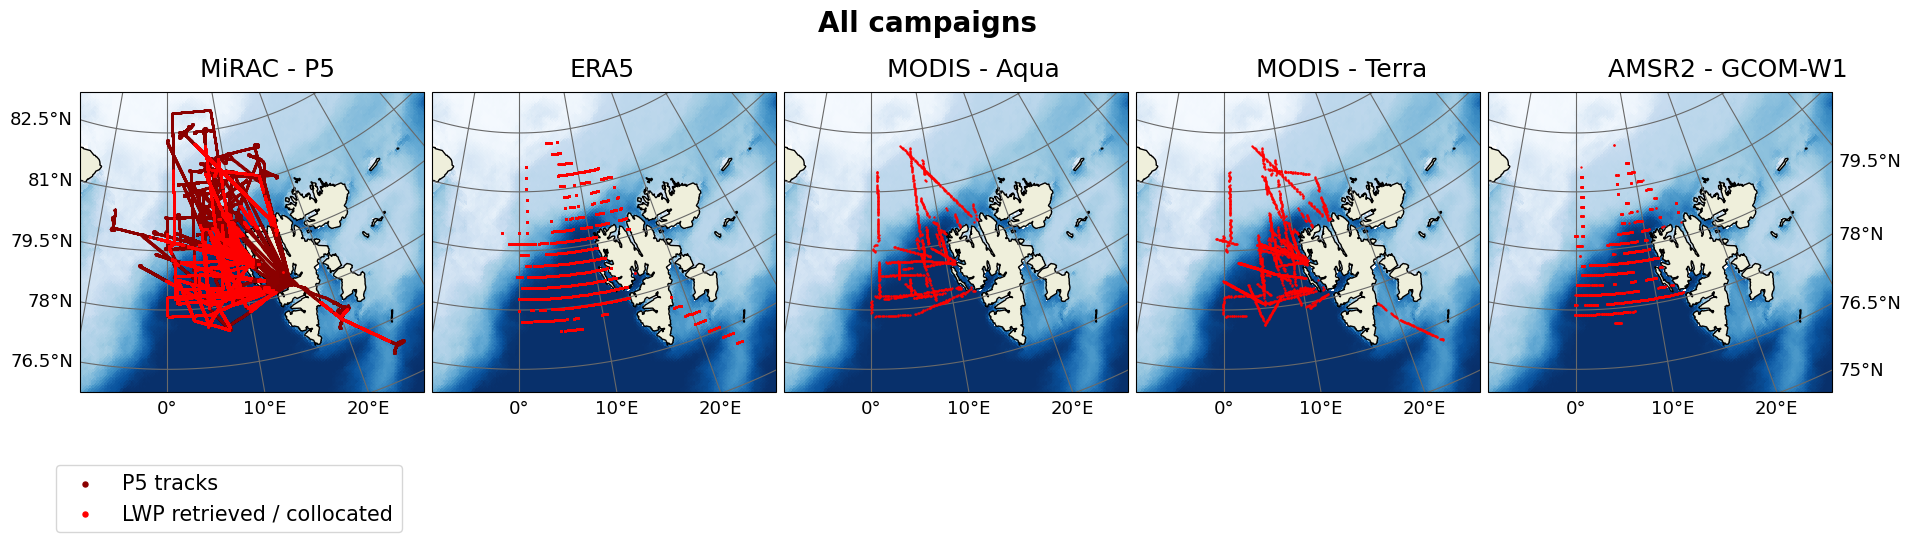

In [30]:
fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(19,5),sharey=True,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()})

for col,dataset in enumerate(datasets):

    axs[col].set_extent([-9., 27.25, 75.75, 82.75], crs=ccrs.PlateCarree())

    # plot sea-ice concentration
    axs[col].pcolormesh(
        sic_avg_all_campaigns.lon,sic_avg_all_campaigns.lat,sic_avg_all_campaigns,
        cmap='Blues_r',
        transform=ccrs.PlateCarree())

    axs[col].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

    gl = axs[col].gridlines(color='dimgray',draw_labels=True,
                            x_inline=False, y_inline=False,
                            zorder=1,transform=ccrs.PlateCarree())
    gl.rotate_labels = False

    if col == 0:
        gl.right_labels = False
        gl.top_labels = False
    if col in [1,2,3]:
        gl.right_labels = False
        gl.left_labels = False
        gl.top_labels = False
    if col == 4:
        gl.left_labels = False
        gl.top_labels = False
    
    gl.xlabel_style={'size': 13}
    gl.ylabel_style={'size': 13}

    if col == 0:
        
        axs[col].scatter(lwp_campaign_p5.lon,lwp_campaign_p5.lat,
                     color='darkred',
                     label='P5 tracks',
                     #alpha=0.15,
                     s=0.05,
                     zorder=2,
                     transform=ccrs.PlateCarree())

        axs[col].scatter(lwp_campaign_p5_ocean.lon,lwp_campaign_p5_ocean.lat,
                     color='red',
                     label='LWP retrieved / collocated',
                     s=0.5,
                     zorder=2,
                     transform=ccrs.PlateCarree())
        
    if col == 1:

        axs[col].scatter(lwp_campaign_era5.lon,lwp_campaign_era5.lat,
                     color='red',
                     s=0.5,
                     zorder=2,
                     transform=ccrs.PlateCarree())
    if col > 1:

        axs[col].scatter(dataset.lon,dataset.lat,
                     color='red',
                     s=0.5,
                     zorder=2,
                     transform=ccrs.PlateCarree())
        
axs[0].text(0.35,1.05,labels[0],transform=axs[0].transAxes)
axs[1].text(0.4,1.05,labels[1],transform=axs[1].transAxes)
axs[2].text(0.3,1.05,labels[2],transform=axs[2].transAxes)
axs[3].text(0.35,1.05,labels[3],transform=axs[3].transAxes)
axs[4].text(0.35,1.05,labels[4],transform=axs[4].transAxes)

axs[2].text(0.1,1.2,'All campaigns',fontweight='bold',fontsize=20,transform=axs[2].transAxes)

lgd = axs[0].legend(loc="lower left",bbox_to_anchor=(-0.1,-0.5))
lgd.legendHandles[0]._sizes = [13]
lgd.legendHandles[1]._sizes = [13]

#handles, lgd_labels = axs[0].get_legend_handles_labels()
#legend = fig.legend(
#    handles, lgd_labels, 
#    prop={'size': 16}, loc='lower center', 
#    ncol=2, bbox_to_anchor=(0.48,-0.01))

plt.savefig('/home/mringel/lwp_project/figures/figures4paper/map_of_collocations_all_campaigns.png',
            bbox_inches='tight',
            dpi=200)

/tmp/ipykernel_2719709/2741113251.py:47: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgd.legendHandles[0]._sizes = [labelsize]
/tmp/ipykernel_2719709/2741113251.py:48: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgd.legendHandles[1]._sizes = [labelsize]


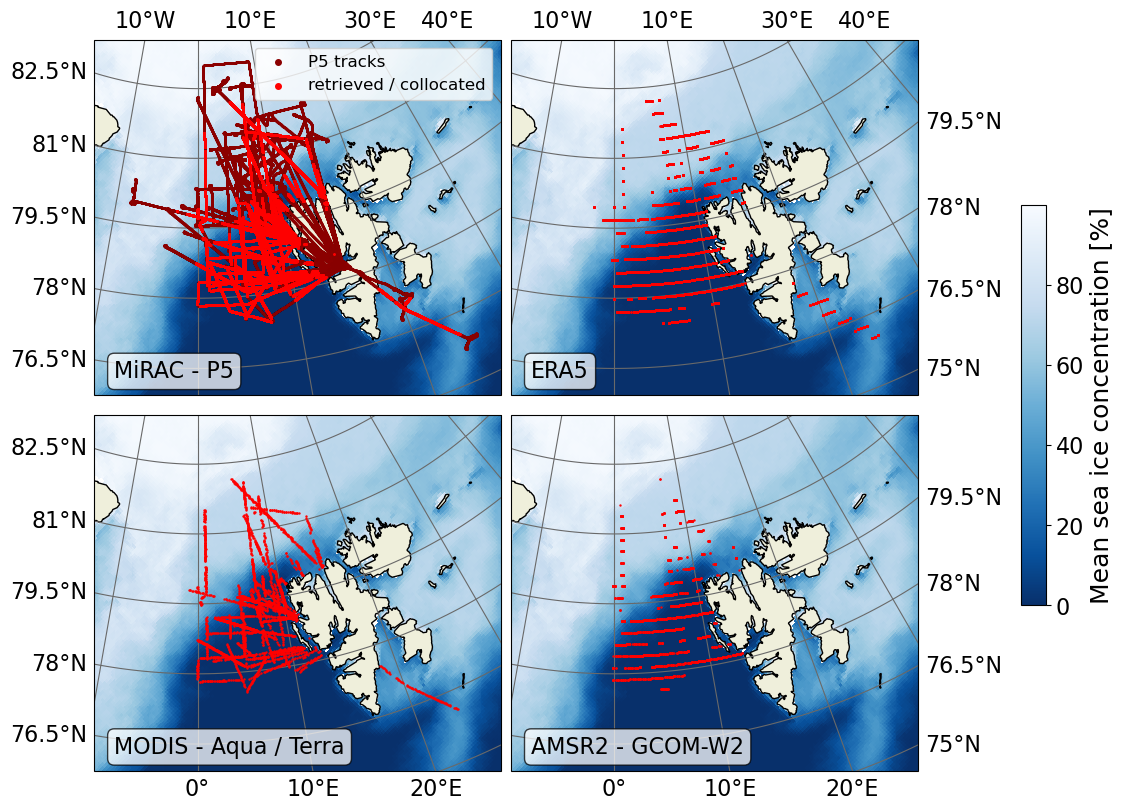

In [38]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(10,8),sharey=True,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()})

textbox = dict(boxstyle='round', facecolor='white', alpha=0.75)

labelsize = 16

for row in range(2):
    for col in range(2):

        axs[row,col].set_extent([-9., 27.25, 75.75, 82.75], crs=ccrs.PlateCarree())

        # plot sea-ice concentration
        sic = axs[row,col].pcolormesh(
            sic_avg_all_campaigns.lon,sic_avg_all_campaigns.lat,sic_avg_all_campaigns,
            cmap='Blues_r',
            transform=ccrs.PlateCarree())

        axs[row,col].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

# MiRAC - P5
gl = axs[0,0].gridlines(color='dimgray',draw_labels=True,
                        x_inline=False, y_inline=False,
                        zorder=1,transform=ccrs.PlateCarree())
gl.xlabel_style={'size': labelsize}
gl.ylabel_style={'size': labelsize}
gl.rotate_labels = False
gl.right_labels = False
gl.bottom_labels = False

axs[0,0].scatter(lwp_campaign_p5.lon,lwp_campaign_p5.lat,
                color='darkred',
                label='P5 tracks',
                #alpha=0.15,
                s=0.05,
                zorder=2,
                transform=ccrs.PlateCarree())
axs[0,0].scatter(lwp_campaign_p5_ocean.lon,lwp_campaign_p5_ocean.lat,
                color='red',
                label='retrieved / collocated',
                s=0.5,
                zorder=2,
                transform=ccrs.PlateCarree())
axs[0,0].text(0.05,0.1,'MiRAC - P5',fontsize=labelsize,transform=axs[0,0].transAxes,
              verticalalignment='top', bbox=textbox)
lgd = axs[0,0].legend(loc='upper right',fontsize=12)
lgd.legendHandles[0]._sizes = [labelsize]
lgd.legendHandles[1]._sizes = [labelsize]

# ERA5 
gl = axs[0,1].gridlines(color='dimgray',draw_labels=True,
                        x_inline=False, y_inline=False,
                        zorder=1,transform=ccrs.PlateCarree())
gl.xlabel_style={'size': labelsize}
gl.ylabel_style={'size': labelsize}
gl.rotate_labels = False
gl.left_labels = False
gl.bottom_labels = False
axs[0,1].scatter(lwp_campaign_era5.lon,lwp_campaign_era5.lat,
                color='red',
                #alpha=0.15,
                s=0.5,
                zorder=2,
                transform=ccrs.PlateCarree())
axs[0,1].text(0.05,0.1,'ERA5',fontsize=labelsize,transform=axs[0,1].transAxes,
              verticalalignment='top', bbox=textbox)

# MODIS - AQUA / TERRA
gl = axs[1,0].gridlines(color='dimgray',draw_labels=True,
                        x_inline=False, y_inline=False,
                        zorder=1,transform=ccrs.PlateCarree())
gl.xlabel_style={'size': labelsize}
gl.ylabel_style={'size': labelsize}
gl.rotate_labels = False
gl.right_labels = False
gl.top_labels = False
axs[1,0].scatter(lwp_campaign_aqua.lon,lwp_campaign_aqua.lat,
                color='red',
                #alpha=0.15,
                s=0.5,
                zorder=2,
                transform=ccrs.PlateCarree())
axs[1,0].scatter(lwp_campaign_terra.lon,lwp_campaign_terra.lat,
                color='red',
                #alpha=0.15,
                s=0.5,
                zorder=2,
                transform=ccrs.PlateCarree())
axs[1,0].text(0.05,0.1,'MODIS - Aqua / Terra',fontsize=labelsize,transform=axs[1,0].transAxes,
              verticalalignment='top', bbox=textbox)

# AMSR2 - GCOM-W2
gl = axs[1,1].gridlines(color='dimgray',draw_labels=True,
                        x_inline=False, y_inline=False,
                        zorder=1,transform=ccrs.PlateCarree())
gl.xlabel_style={'size': labelsize}
gl.ylabel_style={'size': labelsize}
gl.rotate_labels = False
gl.left_labels = False
gl.top_labels = False
axs[1,1].scatter(lwp_campaign_amsr.lon,lwp_campaign_amsr.lat,
                color='red',
                #alpha=0.15,
                s=0.5,
                zorder=2,
                transform=ccrs.PlateCarree())
axs[1,1].text(0.05,0.1,'AMSR2 - GCOM-W2',fontsize=labelsize,transform=axs[1,1].transAxes,
              verticalalignment='top', bbox=textbox)

#cax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cax = fig.add_axes([1.015, 0.25, 0.025, 0.5])
cbar = fig.colorbar(sic, cax=cax, orientation='vertical', label='Mean sea ice concentration [%]')

cbar.ax.tick_params(labelsize=16) 

plt.savefig('/home/mringel/lwp_project/figures/figures4poster/map_of_collocations_all_campaigns_v2.png',
            bbox_inches='tight',
            dpi=200)

#### Plot collocated coordinates for each campaign, for each data product

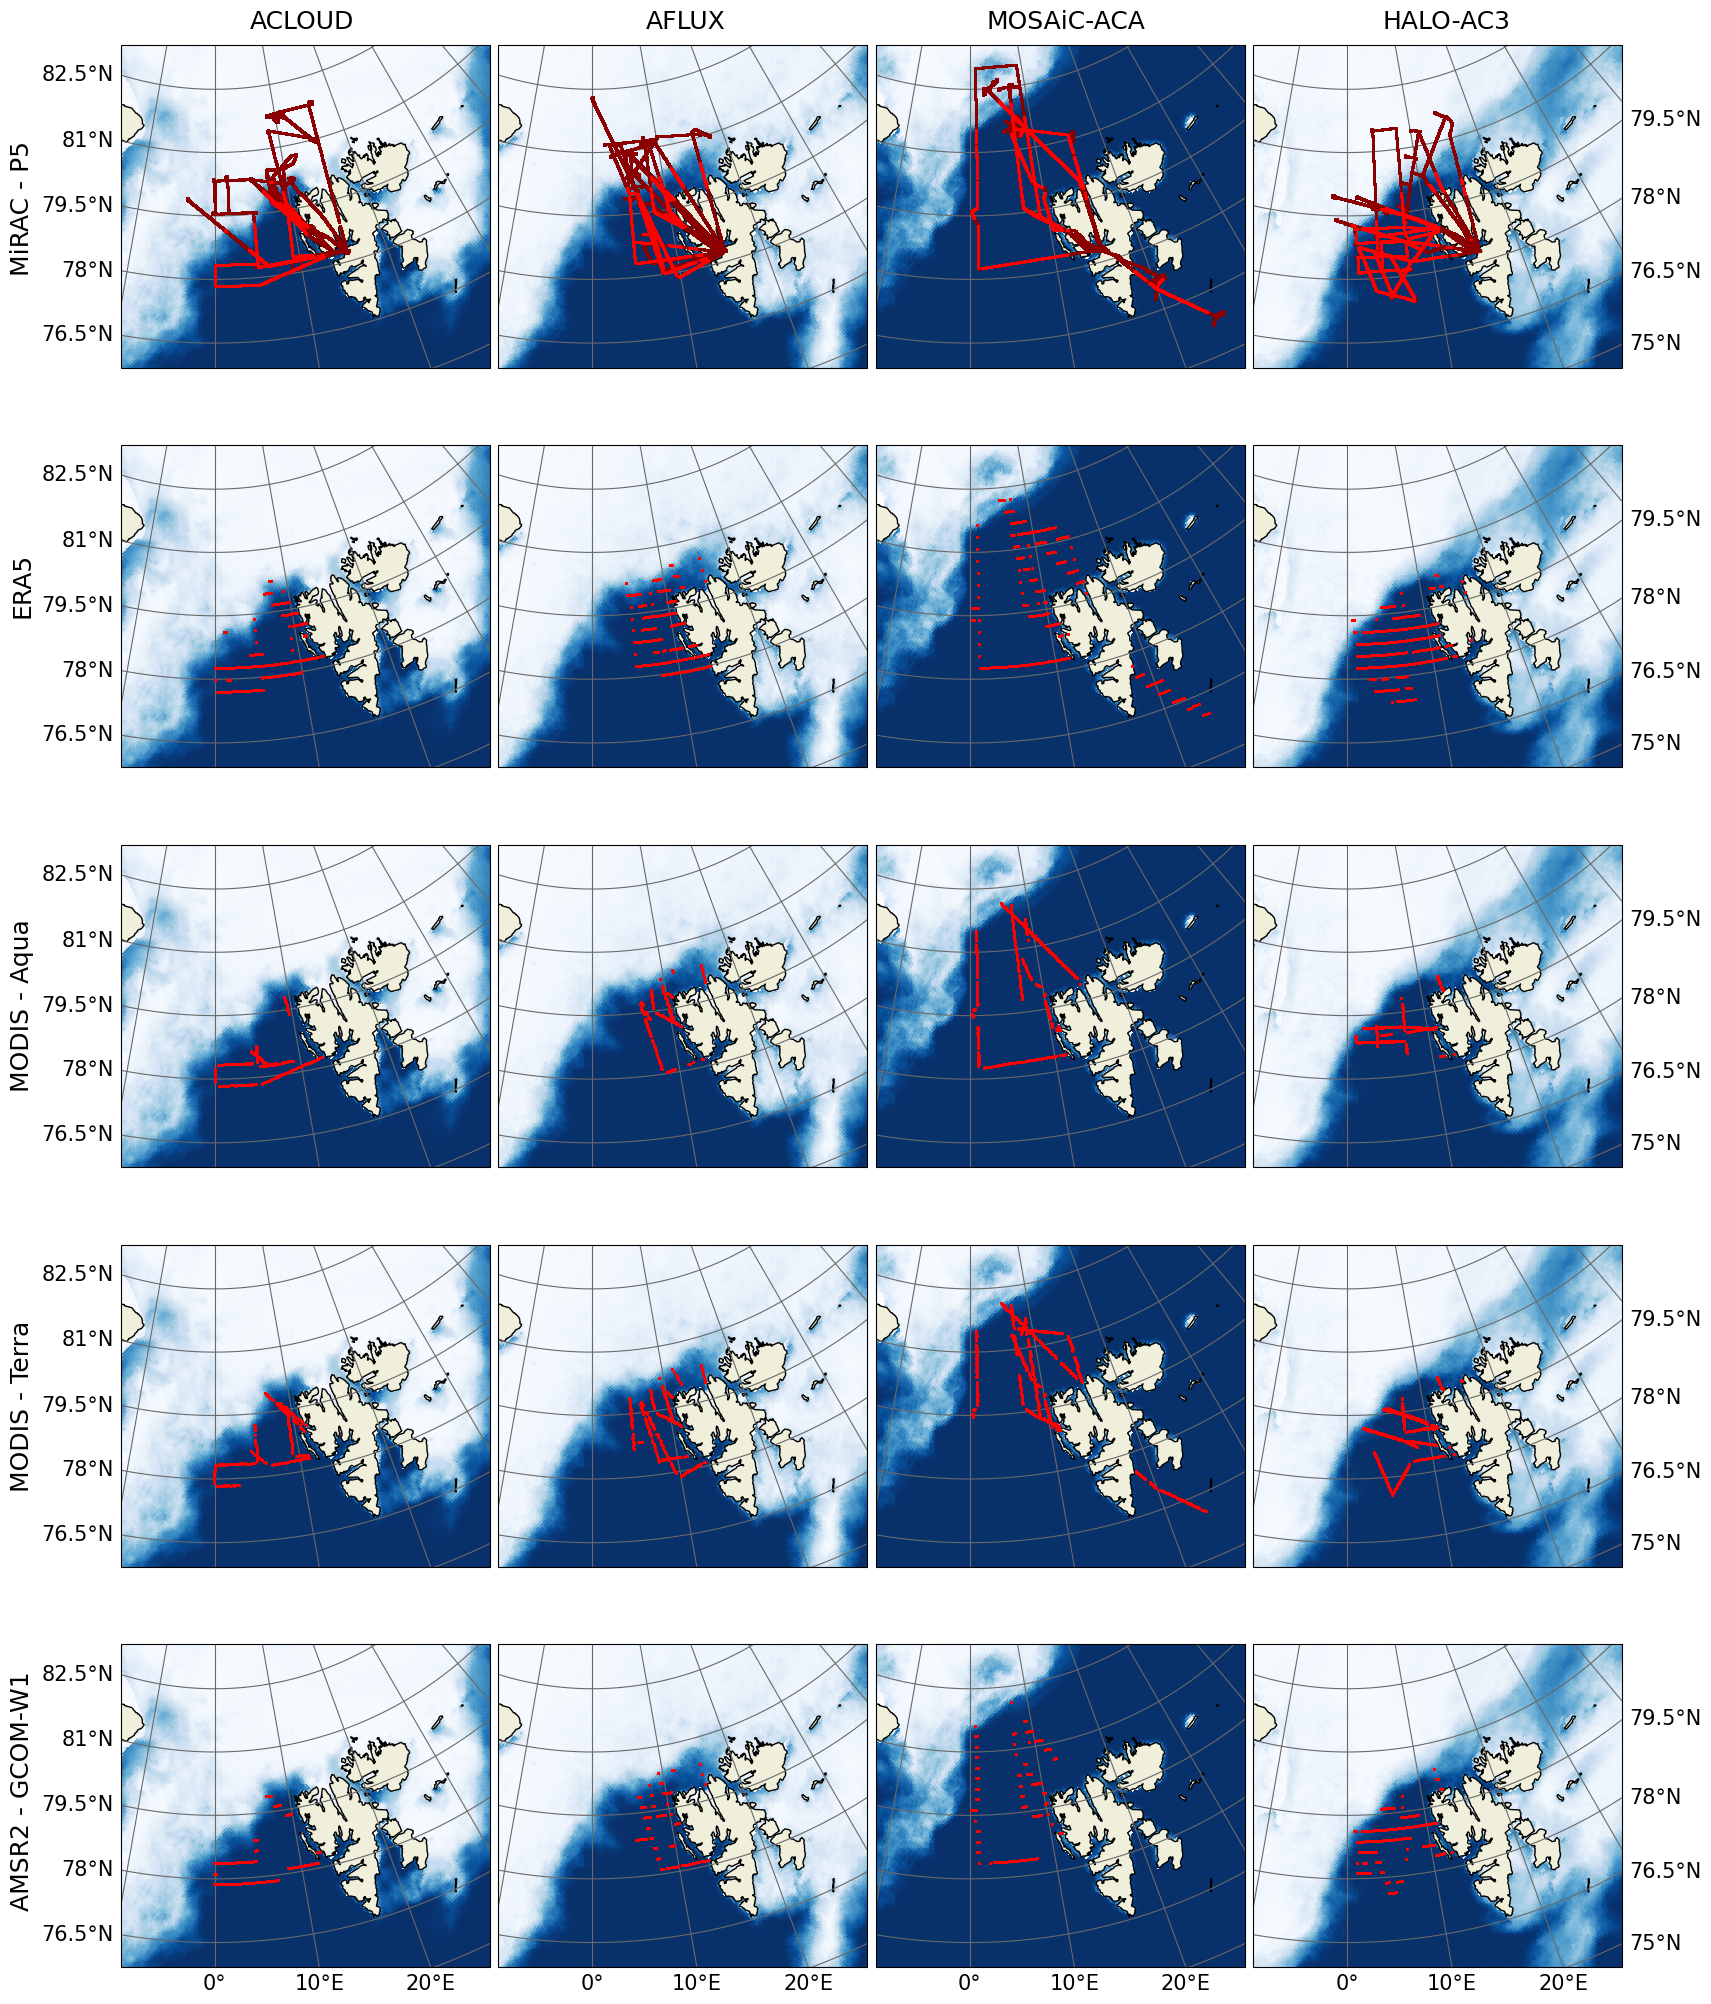

In [16]:
fig, axs = plt.subplots(nrows=5,ncols=4,figsize=(17,20),sharey=True,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()})

for col,campaign in enumerate(campaigns):

    flight_dates = [meta[campaign]['P5'][flight_id]['date'] for flight_id in list(cat[campaign]['P5']['MiRAC-A'])]

    p5_all = lwp_campaign_p5.sel(time=slice(flight_dates[0],flight_dates[-1]))
    p5_ocean = lwp_campaign_p5_ocean.sel(time=slice(flight_dates[0],flight_dates[-1]))
    era5 = lwp_campaign_era5.sel(time=slice(flight_dates[0],flight_dates[-1]))
    aqua = lwp_campaign_aqua.sel(time=slice(flight_dates[0],flight_dates[-1]))
    terra = lwp_campaign_terra.sel(time=slice(flight_dates[0],flight_dates[-1]))
    amsr = lwp_campaign_amsr.sel(time=slice(flight_dates[0],flight_dates[-1]))

    sic = sic_datasets[col]
    
    for row,dataset in enumerate(datasets):
    
        #axs[col] = plt.axes(projection=ccrs.NorthPolarStereo())
        axs[row,col].set_extent([-9., 27.25, 75.75, 82.75], crs=ccrs.PlateCarree())

        # plot sea-ice concentration
        axs[row,col].pcolormesh(
            sic.lon,sic.lat,sic.sic,
            cmap='Blues_r',
            transform=ccrs.PlateCarree())

        #ax.add_feature(cartopy.feature.OCEAN, zorder=0)
        axs[row,col].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

        gl = axs[row,col].gridlines(color='dimgray',draw_labels=True,
                                x_inline=False, y_inline=False,
                                zorder=1,transform=ccrs.PlateCarree())
        gl.rotate_labels = False
        gl.top_labels = False
        gl.bottom_labels = False
        gl.left_labels = False
        gl.right_labels = False
        if col == 0:
            gl.left_labels = True
        if col == 3:
            gl.right_labels = True
        if row == 4:
            gl.bottom_labels = True  
        gl.xlabel_style={'size': 15}
        gl.ylabel_style={'size': 15}
    
        axs[0,col].scatter(p5_all.lon,p5_all.lat,
                             color='darkred',
                             #alpha=0.15,
                             s=1.,
                             zorder=2,
                             transform=ccrs.PlateCarree())
        axs[0,col].scatter(p5_ocean.lon,p5_ocean.lat,
                             color='red',
                             #alpha=0.15,
                             s=1.,
                             zorder=2,
                             transform=ccrs.PlateCarree())
            
        axs[1,col].scatter(era5.lon,era5.lat,
                        color='red',
                        s=1.,
                        zorder=2,
                        transform=ccrs.PlateCarree())

        axs[2,col].scatter(aqua.lon,aqua.lat,
                        color='red',
                        s=1.,
                        zorder=2,
                        transform=ccrs.PlateCarree())
        
        axs[3,col].scatter(terra.lon,terra.lat,
                        color='red',
                        s=1.,
                        zorder=2,
                        transform=ccrs.PlateCarree())
        
        axs[4,col].scatter(amsr.lon,amsr.lat,
                        color='red',
                        s=1.,
                        zorder=2,
                        transform=ccrs.PlateCarree())

axs[0,0].text(0.35,1.05,campaigns[0],transform=axs[0,0].transAxes)
axs[0,1].text(0.4,1.05,campaigns[1],transform=axs[0,1].transAxes)
axs[0,2].text(0.3,1.05,campaigns[2],transform=axs[0,2].transAxes)
axs[0,3].text(0.35,1.05,campaigns[3],transform=axs[0,3].transAxes)

axs[0,0].text(-0.3,0.3,labels[0],rotation=90,transform=axs[0,0].transAxes)
axs[1,0].text(-0.3,0.48,labels[1],rotation=90,transform=axs[1,0].transAxes)
axs[2,0].text(-0.3,0.25,labels[2],rotation=90,transform=axs[2,0].transAxes)
axs[3,0].text(-0.3,0.25,labels[3],rotation=90,transform=axs[3,0].transAxes)
axs[4,0].text(-0.3,0.19,labels[4],rotation=90,transform=axs[4,0].transAxes)

plt.savefig('/home/mringel/lwp_project/figures/map_of_collocations_each_campaign.png',
            bbox_inches='tight',
            dpi=200)